## Downstream Task: ImageWang

At the heart of this experiment we are trying to answer: 

> What is better: the best trained network starting with *random* weights, or the best trained network starting with weights generated from a *pretext* task?

This may seem obvious but it's important to keep in mind when designing our experiments. In order to train a network with random weights in the best possible way, we will use the approach that gives the highest accuracy when training from scratch on [Imagenette](https://github.com/fastai/imagenette/tree/58a63175a2c6457650289d32741940d6a7d58fbf).

To be honest, I'm not sure what the best possible way to train a network that has been initialized with pretext weights. Therefore we will try both training the only head of the network and training the entire network with discriminitive fine-tuning.

This gives us three scenarios we'd like to compare:

1. Training an entire model that is initialized with random weights.
2. Training the head of a model that is initialized with weights generated on a pretext task.
3. Training an entire model that is initialized with weights generated on a pretext task.


For our experiments here we'll continue using the [ImageWang](https://github.com/fastai/imagenette/blob/master/README.md) dataset. It contains a curated subset of images from the original Imagenet dataset.

It contains:

- A `/train` folder with 20 classes
- A `/val` folder with 10 classes (all of which are in /train)
- An `/unsup` folder with miscellaneous unlabelled images

In [1]:
import torch

from functools import partial
from torch.nn import CrossEntropyLoss
from torchvision.models import resnet34

from fastai2.optimizer import ranger, Adam, SGD, RMSProp

from pathlib import Path

from fastai2.metrics import accuracy, top_k_accuracy
from fastai2.basics import DataBlock, RandomSplitter
from fastai2.learner import Learner
from fastai2.torch_core import num_distrib
from fastai2.callback.schedule import fit_flat_cos

from fastai2.data.block import CategoryBlock
from fastai2.data.transforms import (GrandparentSplitter, get_image_files,
                                     parent_label, Normalize, RegexLabeller, 
                                     parent_label)
from fastai2.data.external import URLs, untar_data

from fastai2.layers import MishJit, MaxPool, LabelSmoothingCrossEntropy

from fastai2.vision.all import ImageBlock, get_image_files, imagenet_stats
from fastai2.vision.data import ImageDataBunch
from fastai2.vision.models.xresnet import xresnet50, xresnet34
from fastai2.vision.augment import aug_transforms, RandomResizedCrop, RandTransform, FlipItem
from fastai2.vision.learner import cnn_learner, cnn_config, model_meta, _default_meta


from fastcore.utils import num_cpus

## Random Weights Baseline

Let's train a completely random network in the best way we know how. The [Imagenette Leaderboard](https://github.com/fastai/imagenette/) contains hyperparameters that give the highest accuracy when trained on the Imagenette dataset (a subset of Imagenet). 

We will use all the tips and tricks from [training Imagenette](https://github.com/fastai/imagenette/tree/58a63175a2c6457650289d32741940d6a7d58fbf).

This approach is taken from: [train_imagenette.py](https://github.com/fastai/fastai2/blob/3faec089e511ee68330dfdc182add8c863df3ecd/nbs/examples/train_imagenette.py)

As of January 2020 the [best parameters](https://github.com/fastai/imagenette/blob/58a63175a2c6457650289d32741940d6a7d58fbf/2020-01-train.md) are:

```
--lr 8e-3 
--sqrmom 0.99 
--mom 0.95 
--eps 1e-6 
--bs 64 
--opt ranger 
--sa 1
--fp16 1 
--arch xse_resnext50 
--pool MaxPool
```

In [66]:
# Default parameters
gpu=None
lr=1e-2
size=128
sqrmom=0.99
mom=0.9
eps=1e-6
epochs=100
bs=64
mixup=0.
opt='ranger',
arch='xresnet50'
sh=0.
sa=0
sym=0
beta=0.
act_fn='MishJit'
fp16=0
pool='AvgPool',
dump=0
runs=1
meta=''

In [67]:
#TODO: Use xse-resnext50

# Chosen parameters
lr=8e-3
sqrmom=0.99
mom=0.95
eps=1e-6
bs=64 
opt='ranger'
sa=1
fp16=0               #NOTE: My GPU cannot run fp16 :'(
arch='xresnet50' 
pool='MaxPool'

gpu=0

# NOTE: Normally loaded from their corresponding string
# CHANGE: I am using xresnet34 instead of xse_resnext50
m = xresnet34
act_fn = MishJit
pool = MaxPool

runs = 3

In [68]:
def get_dbunch(size, bs, sh=0., workers=None):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label)
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) if sh else None
    return dblock.databunch(source, path=source, bs=bs, num_workers=workers,
                            item_tfms=item_tfms, batch_tfms=batch_tfms)

In [82]:
# Using ranger (RAdam + lookahead) optimization
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [83]:
size = 128
bs = 64

dbunch = get_dbunch(size, bs, sh=sh)
if not gpu: print(f'lr: {lr}; size: {size}; sqrmom: {sqrmom}; mom: {mom}; eps: {eps}')

lr: 0.008; size: 128; sqrmom: 0.99; mom: 0.95; eps: 1e-06


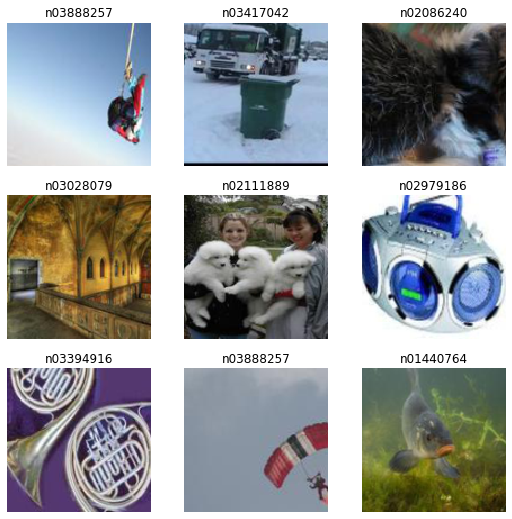

In [84]:
dbunch.show_batch()

In [72]:
for run in range(runs):
        print(f'Run: {run}')
        learn = Learner(dbunch, m(c_out=20, act_cls=act_fn, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        #n_gpu = torch.cuda.device_count()
        #if gpu is None and n_gpu: learn.to_parallel()
        if num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.675512,3.304652,0.027997,0.459150,00:20
1,1.485857,2.984850,0.120641,0.578519,00:19
2,1.357324,2.943504,0.131077,0.566302,00:20
3,1.283522,2.980708,0.156783,0.557139,00:20
4,1.223435,2.420366,0.291677,0.786969,00:20
5,1.185596,2.476095,0.283787,0.775006,00:20
6,1.131483,2.472425,0.292950,0.739628,00:20
7,1.084230,2.342151,0.318402,0.805039,00:20
8,1.068517,2.266932,0.373377,0.805294,00:21
9,1.031578,2.590108,0.305421,0.720285,00:21


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.734124,3.291914,0.040977,0.401883,00:21
1,1.477132,3.098282,0.080682,0.609061,00:20
2,1.351498,2.960411,0.112242,0.549758,00:20
3,1.275236,3.121611,0.100789,0.516416,00:20
4,1.219254,2.720079,0.229066,0.690761,00:20
5,1.188316,2.522477,0.274879,0.740901,00:20
6,1.141736,2.275449,0.359888,0.815220,00:20
7,1.101905,2.711408,0.250445,0.687452,00:20
8,1.076652,2.272375,0.363960,0.811657,00:21
9,1.050504,2.838859,0.226775,0.634767,00:21


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.677942,3.200671,0.061593,0.515907,00:20
1,1.464838,2.978966,0.122678,0.600662,00:20
2,1.360498,2.583995,0.201833,0.727157,00:20
3,1.280848,2.894117,0.185034,0.677781,00:20
4,1.221628,2.532455,0.269534,0.724612,00:20
5,1.177515,2.315983,0.351743,0.828710,00:20
6,1.145927,2.329652,0.335200,0.799949,00:20
7,1.095773,2.568758,0.289896,0.712904,00:20
8,1.074329,2.395371,0.318147,0.764317,00:20
9,1.031189,2.485418,0.311021,0.745737,00:20


When I run the above for 3 runs I get:

- Run 1: 0.589972
- Run 2: 0.577501
- Run 3: 0.577755

This gives us a random weights baseline accuracy of **58.2%**.

## Pretext Weights: Frozen Network 

Now that we've got a random weights baseline, we'd like to see whether training a network starting with pretext weights gives us any improvement. For this experiment we will exclusively train the head of our network for `100` epochs.

In [73]:
for run in range(runs):
        print(f'Run: {run}')
        #CHANGE: No self-attention
        sa = 0
        learn = Learner(dbunch, m(c_out=20, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        n_gpu = torch.cuda.device_count()
        if gpu is None and n_gpu: learn.to_parallel()
        if num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`
            
        # Load weights generated from training on our pretext task
        state_dict = torch.load('imagewang_patches_15_epochs.pth')
        # HACK: If we don't have all of the parameters for our learner, we get an error
        linear_layer = learn.model[-1]
        state_dict['11.weight'] = linear_layer.weight
        state_dict['11.bias'] = linear_layer.bias
        
        learn.model.load_state_dict(state_dict)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.513578,3.643311,0.023161,0.465513,00:18
1,1.369965,2.964664,0.126495,0.595062,00:18
2,1.285168,3.598583,0.137949,0.531178,00:19
3,1.229051,2.585528,0.214558,0.725121,00:19
4,1.145225,2.908213,0.186816,0.690252,00:20
5,1.109486,2.289974,0.358106,0.796895,00:21
6,1.077972,2.134375,0.392466,0.838890,00:20
7,1.051661,2.533042,0.271825,0.742937,00:19
8,1.010613,3.023141,0.197506,0.748028,00:19
9,0.999229,2.954278,0.220667,0.653092,00:19


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.511265,3.189103,0.053703,0.418427,00:18
1,1.380117,3.225134,0.052431,0.487401,00:18
2,1.290818,2.885159,0.170272,0.681344,00:19
3,1.210460,3.179275,0.209214,0.661491,00:18
4,1.154200,3.234938,0.273097,0.651056,00:18
5,1.117009,2.186315,0.373377,0.838636,00:18
6,1.068572,2.428925,0.313820,0.793586,00:18
7,1.028249,2.423136,0.300331,0.786205,00:18
8,1.024330,2.711064,0.247900,0.681853,00:18
9,0.981967,2.509013,0.319674,0.764826,00:18


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.538060,3.024384,0.094681,0.585391,00:18
1,1.401626,3.070369,0.125477,0.579537,00:18
2,1.295690,2.791274,0.202087,0.623314,00:18
3,1.214103,3.434046,0.121150,0.538559,00:18
4,1.169317,3.135718,0.152711,0.515144,00:18
5,1.104913,2.259519,0.363451,0.810639,00:18
6,1.065501,2.293558,0.347162,0.816493,00:18
7,1.045226,2.349330,0.349453,0.806567,00:17
8,1.004658,2.078099,0.434462,0.838890,00:18
9,0.979958,2.330809,0.350216,0.807839,00:18


When I run the above for 3 runs I get:

- Run 1: 0.627641
- Run 2: 0.612879
- Run 3: 0.623568

This gives us an average accuracy of **62.1%**.

## Pretext Weights: Frozen Network + Discriminitive Learning

We've already beaten the network initialized with random weights, but it seems unlikely that fine-tuning the head of a network initialized with pretext weights is the best way to train.

In this experiment we initialize our network using the weights generated by pretraining our network on a pretext task. We will train the head of our network for `5` epochs and then use discriminitive learning rates to train the rest of the network for `95` epochs.

When we fine-tune we will use a slice from `lr//100` to `lr`. This is taken from fastai's [`.fine_tune()`](https://github.com/fastai/fastai2/blob/c942b186b032dcb4d42c95f56893957a24a4f96d/fastai2/callback/schedule.py#L130).

**Some concerns**:
- I am essentially trying to mix "the best way to train with random weights" with "the best way to train with ImageNet weights". Can these approaches be mixed? I feel like I lack a necessary understanding of all the moving parts to say how they will behave once I combine them.
- I am using `fit_flat_cos()` because I'm using the `ranger` optimizer which reduces the need for learning rate warmup. I have not seen any examples of fine-tuning with this approach.
- I am not setting `pct_start`. Most examples I've seen set this. (They also use `.fit_one_cycle()`)

In [75]:
runs = 3
for run in range(runs):
        print(f'Run: {run}')
        #CHANGE: No self-attention
        sa = 0
        learn = Learner(dbunch, m(c_out=20, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        #n_gpu = torch.cuda.device_count()
        #if gpu is None and n_gpu: learn.to_parallel()
        if num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`
            
        # Train 15 epochs w/ frozen head
        state_dict = torch.load('imagewang_patches_15_epochs.pth')

        # HACK: If we don't have all of the parameters for our learner, we get an error
        linear_layer = learn.model[-1]
        state_dict['11.weight'] = linear_layer.weight
        state_dict['11.bias'] = linear_layer.bias
        
        learn.model.load_state_dict(state_dict)
        
        # One epoch of fine-tuning
        learn.freeze()
        learn.fit_flat_cos(5, lr, wd=1e-2, cbs=cbs)
        # Remainder is train_imagenette.py approach, but with discriminitive learning rates
        learn.unfreeze()
        learn.fit_flat_cos(epochs - 5, slice(lr//100, lr), wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.529996,3.315605,0.059048,0.565029,00:17
1,1.373688,2.899065,0.161110,0.567320,00:17
2,1.302309,3.667392,0.061084,0.339272,00:18
3,1.207644,2.497210,0.229829,0.735556,00:19
4,1.063345,2.152572,0.382795,0.844999,00:18


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.097490,2.276740,0.348689,0.812930,00:18
1,1.109489,2.442532,0.303131,0.797658,00:18
2,1.081441,2.929733,0.205396,0.616951,00:18
3,1.035262,2.163069,0.412064,0.827437,00:18
4,1.022581,2.344137,0.377959,0.829982,00:18
5,0.985906,2.075964,0.445915,0.851871,00:18
6,0.965721,2.036445,0.454823,0.845253,00:18
7,0.939166,2.017445,0.457623,0.865615,00:18
8,0.925725,1.985904,0.490710,0.856197,00:18
9,0.910142,2.272225,0.379995,0.811657,00:18


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.524246,4.169334,0.002800,0.139221,00:18
1,1.374769,3.152249,0.109188,0.553831,00:18
2,1.297055,2.433602,0.245610,0.764062,00:18
3,1.227789,2.250043,0.321201,0.793332,00:18
4,1.049809,2.116288,0.405447,0.853907,00:18


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.102374,2.355251,0.340036,0.767116,00:18
1,1.107646,2.985494,0.198269,0.631204,00:18
2,1.061379,3.954404,0.042250,0.338509,00:18
3,1.060668,2.257234,0.367269,0.815729,00:18
4,1.026896,2.657831,0.268516,0.739883,00:18
5,0.975730,1.982324,0.461186,0.873250,00:18
6,0.976180,2.163950,0.428353,0.832782,00:18
7,0.944320,2.383223,0.381013,0.831509,00:18
8,0.908381,2.092976,0.463222,0.859761,00:18
9,0.908517,2.142844,0.464240,0.829728,00:18


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.545102,3.497133,0.024434,0.386612,00:18
1,1.380350,3.106708,0.075846,0.508526,00:18
2,1.278159,3.366053,0.069992,0.446424,00:18
3,1.211365,2.649559,0.201323,0.748537,00:18
4,1.061652,2.121045,0.402647,0.855179,00:18


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.112781,2.281345,0.352762,0.804785,00:18
1,1.083363,2.223169,0.332146,0.828710,00:18
2,1.074487,2.841637,0.268007,0.646220,00:18
3,1.055790,3.062832,0.196997,0.620769,00:18
4,1.023164,3.210069,0.147875,0.566302,00:18
5,0.987921,2.027672,0.464495,0.844490,00:18
6,0.972996,2.090364,0.438534,0.857979,00:18
7,0.946976,2.101107,0.453805,0.846271,00:18
8,0.921808,2.309971,0.397557,0.806567,00:18
9,0.913859,2.137138,0.459913,0.830491,00:18


When I run the above for 3 runs I get:

- Run 1: 0.630186
- Run 2: 0.621787
- Run 3: 0.611606

This gives us an average accuracy of **62.1%** (the exact same as before).

## Conclusion

Our three experiments give us:

1. Random weights baseline: `58.2%` accuracy
2. Pretext weights with head fine-tuning: `62.1%` accuracy
3. Pretext weights with head fine-tuning followed by discriminitive learning: `62.1%` accuracy

In summary, we've demonstrated that we can get a modest improvements in downstream accuracy by pre-training a network on a self-supervised pretext task. This is not super exciting in and of itself, but it gives us a good starting point from which to move towards more interesting questions.

Here are some questions we should consider investigating in future notebooks:

- Can we train on pretext for longer and see larger improvements in downstream performance?
- Are 100 epochs of downstream training enough?
- Can we train on multiple pretext tasks and see greater improvements?
- Can we ever hope to compete with pre-trained weights generated from labelled datasets (eg. Imagenet)?
  - What about domains where those pre-trained weights are weaker (eg. medical images)?

# Bonus Round

I have a few lingering concerns that I want to investigate here. It feels somehow *wrong* that we are getting near-identical results when we fine-tune only the head of our model. I have been taught that fine-tuning + discriminitive learning almost always leads to better results.

Let's consider:
1. Varying the number of fine-tuning epochs and using `.fit_flat_cos()+ranger` (we used `flat_cos()+ranger` in all of the above experiments)
2. Varying the number of fine-tuning epochs and using `.fit_one_cycle()+Adam`

### Varying Epochs w/ `fit_flat_cos()+ranger`

As we did above, we will use `fit_flat_cos()+ranger`. However, in this experiment we will also vary the number of epochs of fine-tuning to see if that improves performance.

In [78]:
fine_tune_epochs = [1, 5, 10, 20]
for fine_tune_epoch in fine_tune_epochs:
        print()
        print(f'Run: {fine_tune_epoch}')
        #CHANGE: No self-attention
        sa = 0
        learn = Learner(dbunch, m(c_out=20, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        #n_gpu = torch.cuda.device_count()
        #if gpu is None and n_gpu: learn.to_parallel()
        if num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`
            
        # Train 15 epochs w/ frozen head
        state_dict = torch.load('imagewang_patches_15_epochs.pth')

        # HACK: If we don't have all of the parameters for our learner, we get an error
        linear_layer = learn.model[-1]
        state_dict['11.weight'] = linear_layer.weight
        state_dict['11.bias'] = linear_layer.bias
        
        learn.model.load_state_dict(state_dict)
        
        # One epoch of fine-tuning
        learn.freeze()
        learn.fit_flat_cos(fine_tune_epoch, lr, wd=1e-2, cbs=cbs)
        # Remainder is train_imagenette.py approach, but with discriminitive learning rates
        learn.unfreeze()
        learn.fit_flat_cos(epochs - fine_tune_epoch, slice(lr//100, lr), wd=1e-2, cbs=cbs)


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.469254,2.922135,0.090863,0.577246,00:17


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.408052,2.868651,0.128786,0.573937,00:17
1,1.300081,2.959909,0.121659,0.570374,00:18
2,1.227861,2.594221,0.218122,0.722321,00:18
3,1.163082,3.539074,0.065411,0.395775,00:17
4,1.136351,2.446923,0.301858,0.804276,00:17
5,1.090729,2.204071,0.390939,0.839908,00:18
6,1.059377,2.366518,0.336981,0.797658,00:18
7,1.008323,2.134061,0.409264,0.838636,00:18
8,0.987104,2.271261,0.367524,0.808094,00:18
9,0.964744,2.521991,0.354798,0.742174,00:19



Run: 5


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.539224,3.093761,0.058794,0.514889,00:18
1,1.378124,3.020615,0.106134,0.550522,00:18
2,1.272293,2.596258,0.232120,0.721812,00:18
3,1.205745,3.741980,0.067956,0.372359,00:18
4,1.054045,2.089165,0.412828,0.868669,00:18


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.104812,2.417269,0.302112,0.772207,00:18
1,1.098455,2.597217,0.254263,0.719267,00:18
2,1.072942,2.418541,0.308475,0.769916,00:18
3,1.044050,2.127942,0.405192,0.841690,00:18
4,1.015381,2.474601,0.297531,0.735302,00:18
5,0.989640,2.112203,0.428099,0.832273,00:18
6,0.967080,2.001820,0.453041,0.867651,00:18
7,0.940765,2.209355,0.406210,0.833545,00:18
8,0.931940,2.194411,0.424281,0.821583,00:18
9,0.906232,3.037667,0.208705,0.646729,00:18



Run: 10


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.533466,3.812294,0.027233,0.244592,00:18
1,1.384844,2.569880,0.211504,0.690252,00:18
2,1.274571,4.196347,0.004072,0.206923,00:18
3,1.205085,2.737280,0.177908,0.727157,00:18
4,1.148929,2.438131,0.292186,0.771189,00:18
5,1.110267,2.328525,0.339272,0.778824,00:18
6,1.084307,2.413263,0.332655,0.750573,00:18
7,1.036110,2.237719,0.378213,0.822092,00:18
8,0.954563,1.996505,0.471367,0.859506,00:18
9,0.873947,1.841691,0.526343,0.903029,00:18


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.945026,2.052196,0.458386,0.861542,00:18
1,0.952457,2.065568,0.449224,0.845508,00:18
2,0.961717,2.141104,0.430644,0.821583,00:18
3,0.940382,2.331705,0.380249,0.798167,00:18
4,0.909693,2.483028,0.358361,0.808094,00:18
5,0.906090,2.015529,0.481038,0.868414,00:18
6,0.901307,2.158163,0.443879,0.845253,00:18
7,0.864906,2.265417,0.426826,0.798167,00:18
8,0.859346,1.882258,0.526852,0.880886,00:18
9,0.844688,2.130346,0.486383,0.853143,00:18



Run: 20


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.539572,3.413474,0.067956,0.550013,00:18
1,1.384456,2.894739,0.118351,0.613642,00:18
2,1.301413,2.543686,0.237210,0.737592,00:18
3,1.205154,3.286039,0.109697,0.496055,00:18
4,1.154560,2.389310,0.306694,0.797913,00:18
5,1.114115,2.270216,0.361161,0.813439,00:18
6,1.078739,1.999836,0.457877,0.879104,00:18
7,1.027711,2.359396,0.350980,0.771698,00:18
8,0.998264,2.228836,0.386358,0.821329,00:18
9,0.988997,3.015238,0.228557,0.705269,00:18


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.794024,1.904830,0.540341,0.871978,00:18
1,0.820516,1.897558,0.526597,0.870450,00:18
2,0.820954,1.873947,0.542632,0.882922,00:18
3,0.821464,1.910800,0.535760,0.876559,00:18
4,0.807320,2.225208,0.456605,0.801731,00:18
5,0.799893,1.785216,0.571392,0.887758,00:18
6,0.789397,1.980845,0.513871,0.863324,00:18
7,0.775978,2.056555,0.518453,0.833036,00:18
8,0.768120,2.051982,0.495546,0.827691,00:18
9,0.770557,1.991743,0.538559,0.851616,00:18


Results: 

- 1 Epoch of Fine Tuning: 0.622805
- 5 Epoch of Fine Tuning: 0.617460
- 10 Epoch of Fine Tuning: 0.620769
- 20 Epoch of Fine Tuning: 0.621023

None of these look like noticable improvements over fine-tuning only the head.

### Varying Epochs w/ `fit_one_cycle()+Adam`

Now we will use `fit_one_cycle()+Adam` while varying the number of fine-tuning epochs.

In [79]:
fine_tune_epochs = [1, 5, 10, 20]
for fine_tune_epoch in fine_tune_epochs:
        print()
        print(f'Run: {fine_tune_epoch}')
        #CHANGE: No self-attention
        sa = 0
        opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
        learn = Learner(dbunch, m(c_out=20, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        #n_gpu = torch.cuda.device_count()
        #if gpu is None and n_gpu: learn.to_parallel()
        if num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`
            
        # Train 15 epochs w/ frozen head
        state_dict = torch.load('imagewang_patches_15_epochs.pth')

        # HACK: If we don't have all of the parameters for our learner, we get an error
        linear_layer = learn.model[-1]
        state_dict['11.weight'] = linear_layer.weight
        state_dict['11.bias'] = linear_layer.bias
        
        learn.model.load_state_dict(state_dict)
        
        # One epoch of fine-tuning
        learn.freeze()
        learn.fit_one_cycle(fine_tune_epoch, lr, wd=1e-2, cbs=cbs)
        # Remainder is train_imagenette.py approach, but with discriminitive learning rates
        learn.unfreeze()
        learn.fit_one_cycle(epochs - fine_tune_epoch, slice(lr//100, lr), wd=1e-2, cbs=cbs)


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.506514,2.978077,0.076355,0.564266,00:18


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.337147,2.927245,0.099771,0.664291,00:18
1,1.265191,2.668580,0.165436,0.724612,00:18
2,1.222913,2.565328,0.229066,0.719776,00:18
3,1.191221,2.280792,0.332400,0.797149,00:18
4,1.163273,2.717539,0.207941,0.638330,00:18
5,1.152842,2.425216,0.289387,0.759990,00:18
6,1.161111,2.997486,0.177144,0.675235,00:18
7,1.150103,2.501621,0.301349,0.786205,00:18
8,1.125585,2.646354,0.259863,0.744719,00:18
9,1.115030,2.782027,0.247137,0.751591,00:18



Run: 5


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.687656,5.610854,0.001527,0.414100,00:18
1,1.450919,3.283823,0.063629,0.422245,00:18
2,1.300556,3.411779,0.030542,0.349453,00:18
3,1.133200,2.406985,0.305421,0.790786,00:18
4,1.055730,2.211581,0.361670,0.833036,00:18


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.011154,2.155117,0.392975,0.844744,00:18
1,1.013731,2.134462,0.393993,0.851616,00:18
2,0.989627,2.175185,0.391194,0.852380,00:18
3,0.983671,2.096480,0.421736,0.868923,00:18
4,0.961651,2.333156,0.355307,0.784933,00:18
5,0.977225,2.168170,0.410028,0.827437,00:18
6,0.974362,2.039198,0.447188,0.857725,00:18
7,0.988272,2.040568,0.428862,0.867651,00:18
8,0.998429,2.859938,0.227793,0.669127,00:18
9,0.977052,2.364035,0.349962,0.774497,00:18



Run: 10


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.602362,4.064352,0.010690,0.275643,00:18
1,1.522888,2.740748,0.144566,0.620769,00:18
2,1.415056,2.901857,0.138458,0.551794,00:18
3,1.292118,3.094512,0.109443,0.659201,00:18
4,1.214676,2.802646,0.171545,0.599898,00:18
5,1.108765,2.535777,0.271570,0.732247,00:18
6,1.023877,2.424568,0.322728,0.788241,00:18
7,0.958669,2.050207,0.441843,0.859506,00:18
8,0.906847,1.857557,0.507254,0.902265,00:18
9,0.871877,1.858462,0.506490,0.902265,00:18


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.874335,1.876673,0.504200,0.896920,00:18
1,0.862048,1.856168,0.516671,0.893612,00:18
2,0.866765,1.806882,0.535760,0.899466,00:18
3,0.862297,1.936736,0.485365,0.881904,00:18
4,0.868802,1.860144,0.525325,0.888012,00:18
5,0.857424,2.068115,0.468313,0.860015,00:18
6,0.864664,1.932345,0.512599,0.866124,00:18
7,0.875221,1.947564,0.503436,0.864597,00:18
8,0.891063,1.906422,0.515398,0.881649,00:18
9,0.906602,2.400604,0.381777,0.798422,00:18



Run: 20


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.546384,3.100777,0.064393,0.601425,00:18
1,1.459038,3.423491,0.050140,0.396793,00:18
2,1.425386,3.471123,0.087554,0.430898,00:18
3,1.382705,4.209449,0.003054,0.117842,00:18
4,1.302751,3.354840,0.125986,0.505218,00:18
5,1.214863,3.068868,0.142784,0.514889,00:18
6,1.159070,2.674806,0.206668,0.682871,00:18
7,1.129758,2.232260,0.335709,0.815475,00:18
8,1.074609,2.557004,0.292695,0.727412,00:19
9,1.041140,2.474619,0.319420,0.749809,00:18


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.749551,1.701069,0.595062,0.909646,00:18
1,0.734173,1.748028,0.588699,0.900993,00:18
2,0.738062,1.731898,0.591754,0.911428,00:18
3,0.736418,1.760766,0.585900,0.900229,00:18
4,0.738153,1.926665,0.541359,0.879104,00:18
5,0.751747,1.842832,0.559684,0.883940,00:18
6,0.760180,2.090794,0.499364,0.861797,00:18
7,0.774816,1.955573,0.527106,0.888521,00:18
8,0.785723,1.962587,0.524561,0.874268,00:18
9,0.807330,2.226692,0.440825,0.815475,00:18


Results: 

- 1 Epoch of Fine Tuning: 0.625859
- 5 Epoch of Fine Tuning: 0.625604
- 10 Epoch of Fine Tuning: 0.617205
- 20 Epoch of Fine Tuning: 0.628404

None of these look like noticable improvements over fine-tuning only the head.